In [1]:
import numpy as np
import ogb
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.data import DataLoader
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import ogbg_mol_utils as mu
from utils import get_nx_graph, color_mapper, draw_legend

In [2]:
d_name = 'ogbg-moltoxcast'
dataset = PygGraphPropPredDataset(name=d_name) 

split_idx = dataset.get_idx_split() 
bs = 1
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=bs, shuffle=False)

In [3]:
ecolors = cm.get_cmap('Set2').colors
edge_colors = {kind: ecolors[k] for k, kind in enumerate(mu.allowable_features['possible_bond_type_list'])}
ncolors = cm.get_cmap('twilight').colors
node_colors = {kind: color_mapper(k, ncolors, max_c=7) for k, kind in enumerate(mu.allowable_features['possible_atomic_num_list'])}

def draw_molecule(mol, draw_edge_labels=True, draw_node_labels=False):
    edge_list = mol.edge_index.numpy().T
    edge_feats = {(edge[0], edge[1]): mol.edge_attr[e] for e, edge in enumerate(edge_list)}
    node_feats = {n: mol.x[n] for n in range(mol.num_nodes)}
    edge_labels = {edge: mu.bond_feature_vector_to_dict(edge_feats[edge])['bond_type'][0] for edge in edge_feats}
    node_labels = {node: str(mu.atom_feature_vector_to_dict(node_feats[node])['atomic_num']) for node in node_feats}
    G = get_nx_graph(mol)
    pos = nx.spring_layout(G)
    ecs = [edge_colors[mu.bond_feature_vector_to_dict(edge_feats[edge])['bond_type']] for edge in G.edges]
    ncs = [node_colors[mu.atom_feature_vector_to_dict(node_feats[node])['atomic_num']] for node in G.nodes]
    plt.figure(figsize=(2,2), dpi=250)
    plt.box(False)
    nx.draw_networkx(G, pos=pos, with_labels=False, node_size=5, node_color=ncs, edge_color=ecs, width=1)
    if draw_edge_labels:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=3)
    if draw_node_labels:
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=5)
    plt.show()
    plt.close()
    return    

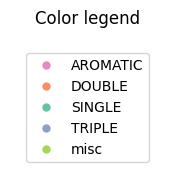

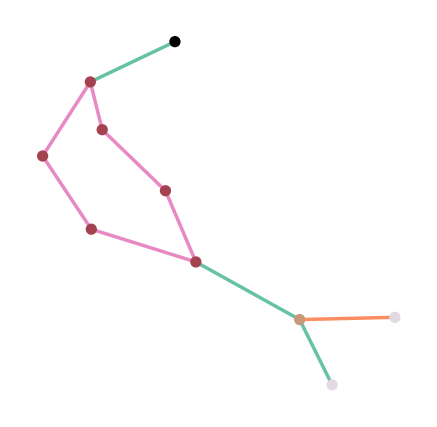

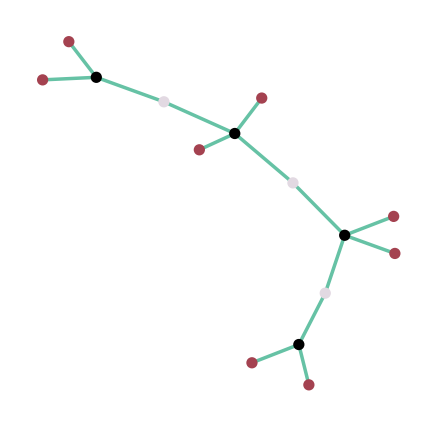

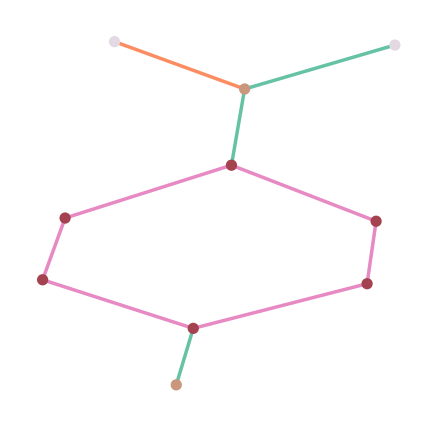

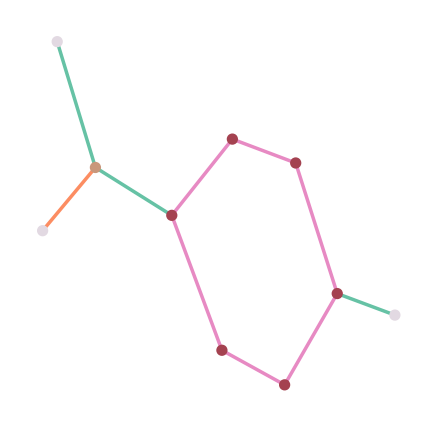

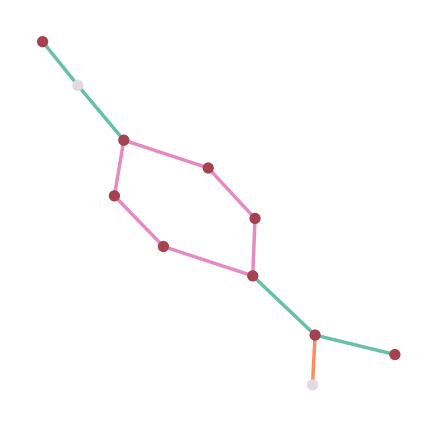

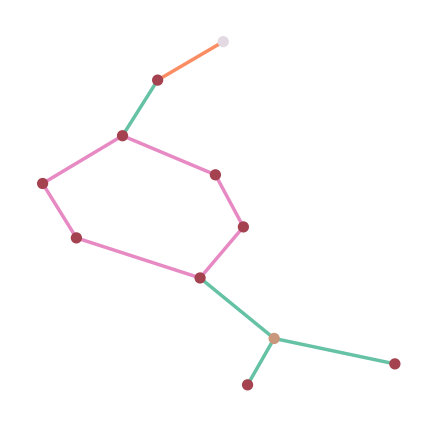

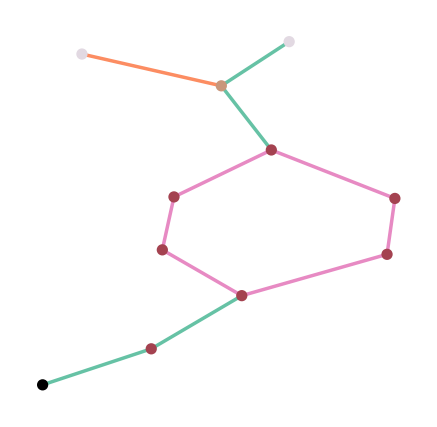

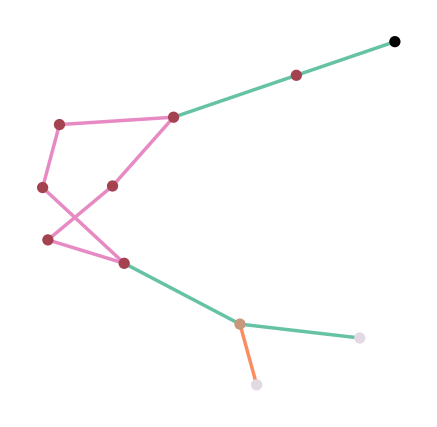

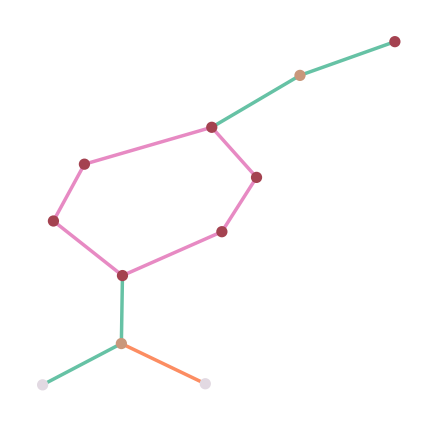

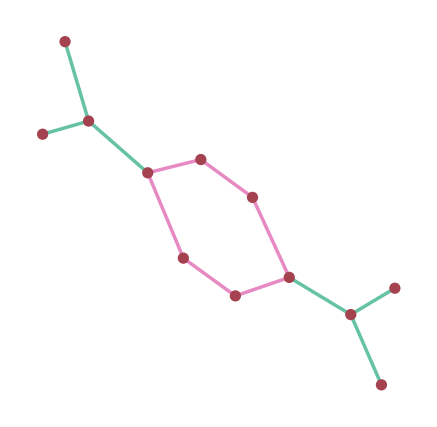

In [4]:
amount = 10
draw_legend(edge_colors)

count = 0
for mol in train_loader:
    count += 1
    draw_molecule(mol, draw_edge_labels=False, draw_node_labels=False)
    if count >= amount:
        break

In [ ]:
max_clique_size = 4
datasets = [
    'ogbg-moltox21',
    'ogbg-moltoxcast',
    'ogbg-molmuv',
    'ogbg-molbace',
    'ogbg-molbbbp',
    'ogbg-molclintox',
    'ogbg-molsider',
    'ogbg-molesol',
    'ogbg-molfreesolv',
    'ogbg-mollipo']

for d_name in datasets:
    dataset = PygGraphPropPredDataset(name=d_name) 
    split_idx = dataset.get_idx_split() 
    train_loader = DataLoader(dataset[split_idx["train"]], batch_size=bs, shuffle=False)
    H = np.zeros((len(train_loader), max_clique_size+1))
    for m, mol in enumerate(train_loader):
        G = get_nx_graph(mol)
        for clique in nx.algorithms.clique.enumerate_all_cliques(G):
            size = len(clique)
            H[m, size] += 1
    print('Dataset: {}'.format(d_name))
    print('Number of overall triangles: {}'.format(H[:,3].sum()))
    print('Number of molecules with at least one triangle: {}'.format((H[:,3]>0).sum()))
    print('Number of molecules with at least one 4-clique: {}'.format((H[:,4]>0).sum()))
    print('Number of overall molecules: {}'.format(H.shape[0]))
    print('-------------------------------------------------')

Dataset: ogbg-moltox21
Number of overall triangles: 100.0
Number of molecules with at least one triangle: 89
Number of molecules with at least one 4-clique: 0
Number of overall molecules: 6264
-------------------------------------------------
Dataset: ogbg-moltoxcast
Number of overall triangles: 97.0
Number of molecules with at least one triangle: 91
Number of molecules with at least one 4-clique: 0
Number of overall molecules: 6860
-------------------------------------------------
